In [1]:
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import convolve
import os
import glob

In [37]:
## HELPER FUNCTIONS
# HELP WITH LOADING AND WRITING TO FILE
# def load_images(PATH, OUT_PATH=None):
#     cap = cv2.VideoCapture(PATH)
#     again = True
#     i = 0
#     imgs = []
#     while again:
#         again, img = cap.read()
#         if again:
#             img_r = cv2.resize(img, None, fx=320/1280, fy=240/720)
#             imgs += [img_r]
#             if not OUT_PATH is None:
#                 #filename = OUT_PATH + "".join([str(0)]*(3-len(str(i)))) + str(i) +'.ppm'
#                 filename = os.path.join(OUT_PATH, 'img_%09d.ppm'%(i+1))
#                 cv2.imwrite(filename, img_r)
#             i += 1
#         else:
#             break
#     return imgs

def load_images(PATH, OUT_PATH=None):
    filenames = glob.glob(PATH)
    i=0
    imgs = []
    for filename in filenames:
        img = cv2.imread(filename)
        img = img[:,:img.shape[1]//2,:]
        img_r = cv2.resize(img, None, fx=320/1280, fy=240/720)
        imgs+=[img_r]
        if not OUT_PATH is None:
            #filename = OUT_PATH + "".join([str(0)]*(3-len(str(i)))) + str(i) +'.ppm'
            img_name = os.path.join(OUT_PATH, 'img_%09d.ppm'%(i+1))
            cv2.imwrite(img_name, img_r)
        i+=1
    return imgs

def load_masks(PATH, OUT_PATH=None):
    filenames = glob.glob(PATH)
    imgs = []
    for filename in filenames:
        img = cv2.imread(filename)
        #img = img[:,:img.shape[1]//2,:]
        img_r = cv2.resize(img, None, fx=320/1280, fy=240/720)
        imgs+=[img_r]
        if not OUT_PATH is None:
            #filename = OUT_PATH + "".join([str(0)]*(3-len(str(i)))) + str(i) +'.ppm'
            img_name = os.path.join(OUT_PATH, filename[28:])
            cv2.imwrite(img_name, img_r)
    return imgs

def create_gif(filenames, PATH):
    kargs = { 'duration': 0.0333 }
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(PATH, images, **kargs)
    
## HELP WITH VISUALIZING 
def imshow_with_trajectory(images, warp_stack, PATH, ij):
    traj_dict = {(0,0):'Width', (0,1):'sin(Theta)', (1,0):'-sin(Theta)', (1,1):'Height', (0,2):'X', (1,2):'Y'}
    i,j = ij
    filenames = []
    for k in range(1,len(warp_stack)):
        f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})

        a0.axis('off')
        a0.imshow(images[k])

        a1.plot(np.arange(len(warp_stack)), np.cumsum(warp_stack[:,i,j]))
        a1.scatter(k, np.cumsum(warp_stack[:,i,j])[k], c='r', s=100)
        a1.set_xlabel('Frame')
        a1.set_ylabel(traj_dict[ij]+' Trajectory')
        
        if not PATH is None:
            filename = PATH + "".join([str(0)]*(3-len(str(k)))) + str(k) +'.png'
            plt.savefig(filename)
            filenames += [filename]
        plt.close()
    return filenames

def get_border_pads(img_shape, warp_stack):
    maxmin = []
    corners = np.array([[0,0,1], [img_shape[1], 0, 1], [0, img_shape[0],1], [img_shape[1], img_shape[0], 1]]).T
    warp_prev = np.eye(3)
    for warp in warp_stack:
        warp = np.concatenate([warp, [[0,0,1]]])
        warp = np.matmul(warp, warp_prev)
        warp_invs = np.linalg.inv(warp)
        new_corners = np.matmul(warp_invs, corners)
        xmax,xmin = new_corners[0].max(), new_corners[0].min()
        ymax,ymin = new_corners[1].max(), new_corners[1].min()
        maxmin += [[ymax,xmax], [ymin,xmin]]
        warp_prev = warp.copy()
    maxmin = np.array(maxmin)
    bottom = maxmin[:,0].max()
    print('bottom', maxmin[:,0].argmax()//2)
    top = maxmin[:,0].min()
    print('top', maxmin[:,0].argmin()//2)
    left = maxmin[:,1].min()
    print('right', maxmin[:,1].argmax()//2)
    right = maxmin[:,1].max()
    print('left', maxmin[:,1].argmin()//2)
    return int(-top), int(bottom-img_shape[0]), int(-left), int(right-img_shape[1])

### CORE FUNCTIONS
## FINDING THE TRAJECTORY
def get_homography(img1, img2, motion = cv2.MOTION_EUCLIDEAN):
    imga = img1.copy().astype(np.float32)
    imgb = img2.copy().astype(np.float32)
    if len(imga.shape) == 3:
        imga = cv2.cvtColor(imga, cv2.COLOR_BGR2GRAY)
    if len(imgb.shape) == 3:
        imgb = cv2.cvtColor(imgb, cv2.COLOR_BGR2GRAY)
    if motion == cv2.MOTION_HOMOGRAPHY:
        warpMatrix=np.eye(3, 3, dtype=np.float32)
    else:
        warpMatrix=np.eye(2, 3, dtype=np.float32)
    warp_matrix = cv2.findTransformECC(templateImage=imga,inputImage=imgb,warpMatrix=warpMatrix, motionType=motion)[1]
    return warp_matrix 

def create_warp_stack(PATH, PATH_M):
    filenames = glob.glob(PATH)
    masks = glob.glob(PATH_M)
    warp_stack = []
    warp_stack_mask = []
    for i, filename in enumerate(filenames[:-1]):
        img1 = cv2.imread(filenames[i])
        img2 = cv2.imread(filenames[i+1])
        wm = get_homography(img1, img2)
        warp_stack += [wm]
        
#         for f in masks:
#             if filename[8:-4]==f[19:-4]:
#                # print(filename[8:-4])
#                 warp_stack_mask+=[wm]
    return np.array(warp_stack), np.array(warp_stack_mask)

def homography_gen(warp_stack):
    H_tot = np.eye(3)
    wsp = np.dstack([warp_stack[:,0,:], warp_stack[:,1,:], np.array([[0,0,1]]*warp_stack.shape[0])])
    for i in range(len(warp_stack)):
        H_tot = np.matmul(wsp[i].T, H_tot)
        yield np.linalg.inv(H_tot)#[:2]


## DETERMINING THE SMOOTHED TRAJECTORY
def gauss_convolve(trajectory, window, sigma):
    kernel = signal.gaussian(window, std=sigma)
    kernel = kernel/np.sum(kernel)
    return convolve(trajectory, kernel, mode='reflect')

def moving_average(warp_stack, sigma_mat):
    x,y = warp_stack.shape[1:]
    original_trajectory = np.cumsum(warp_stack, axis=0)
    smoothed_trajectory = np.zeros(original_trajectory.shape)
    for i in range(x):
        for j in range(y):
            kernel = signal.gaussian(1000, sigma_mat[i,j])
            kernel = kernel/np.sum(kernel)
            smoothed_trajectory[:,i,j] = convolve(original_trajectory[:,i,j], kernel, mode='reflect')
    smoothed_warp = np.apply_along_axis(lambda m: convolve(m, [0,1,-1], mode='reflect'), axis=0, arr=smoothed_trajectory)
    smoothed_warp[:,0,0] = 0
    smoothed_warp[:,1,1] = 0
    return smoothed_warp, smoothed_trajectory, original_trajectory

## APPLYING THE SMOOTHED TRAJECTORY TO THE IMAGES
def apply_warping_fullview(images, warp_stack, PATH=None):
    top, bottom, left, right = get_border_pads(img_shape=images[0].shape, warp_stack=warp_stack)
    H = homography_gen(warp_stack)
    imgs = []
    for i, img in enumerate(images[1:]):
        H_tot = next(H)+np.array([[0,0,left],[0,0,top],[0,0,0]])
        img_warp = cv2.warpPerspective(img, H_tot, (img.shape[1]+left+right, img.shape[0]+top+bottom), flags=cv2.INTER_CUBIC)
        #img_warp = cv2.resize(img_warp, None, fx=320/380, fy=240/293)
        if not PATH is None:
            #filename = PATH + "".join([str(0)]*(3-len(str(i)))) + str(i) +'.ppm'
            filename = os.path.join(PATH, 'img_%09d.ppm'%(i+1))
            cv2.imwrite(filename, img_warp)
        imgs += [img_warp]
    return imgs

def apply_warping_fullview_mask(images, warp_stack, PATH=None, PATH2=None):
    filenames = glob.glob(PATH)
    mask_names = glob.glob(PATH2)
    top, bottom, left, right = get_border_pads(img_shape=images[0].shape, warp_stack=warp_stack)
    H = homography_gen(warp_stack)
#     H2 = homography_gen(warp_stack2)
    imgs = []
    mskstack = []
    for i, filename in enumerate(filenames):
        try:
            H_tot = next(H)+np.array([[0,0,left],[0,0,top],[0,0,0]])
            img = cv2.imread(filename)
            img_warp = cv2.warpPerspective(img, H_tot, (img.shape[1]+left+right, img.shape[0]+top+bottom))
            for f in mask_names:
                if filename[8:-4]==f[19:-4]:
                    msk = cv2.imread(f)
                    mask_warp = cv2.warpPerspective(msk, H_tot, (msk.shape[1]+left+right, msk.shape[0]+top+bottom), flags=cv2.INTER_CUBIC)
                    if not PATH2 is None:
                        mask_warp = cv2.resize(mask_warp, None, fx=320/336, fy=240/254)
                        cv2.imwrite(f, mask_warp)
            #img_warp = cv2.resize(img_warp, None, fx=320/380, fy=240/293)
            if not PATH is None:
                #filename = PATH + "".join([str(0)]*(3-len(str(i)))) + str(i) +'.ppm'
                filename_new = filename
                img_warp = cv2.resize(img_warp, None, fx=320/336, fy=240/254)
                cv2.imwrite(filename_new, img_warp)
            imgs += [img_warp]
        except StopIteration:
                pass
#     for i, mask in enumerate(mask_names):
#         try:
#             H_tot = next(H2)+np.array([[0,0,left],[0,0,top],[0,0,0]])
#             msks = cv2.imread(mask)
#             img_warp = cv2.warpPerspective(msks, H_tot, (img.shape[1]+left+right, img.shape[0]+top+bottom))
#             #img_warp = cv2.resize(img_warp, None, fx=320/380, fy=240/293)
#             if not PATH2 is None:
#                 #filename = PATH + "".join([str(0)]*(3-len(str(i)))) + str(i) +'.ppm'
#                 filename_new = mask
#                 cv2.imwrite(filename_new, img_warp)
#             mskstack += [img_warp]
#         except StopIteration:
#                 pass
    return imgs, mskstack

In [14]:
f = glob.glob('../../Dataset/masks/off_road/*.png')

In [21]:
f[0][19:-4]

'taset/masks/off_road\\left_mask_000000342'

In [38]:
imgs = load_images('../../Dataset/video_on_road/*.ppm', OUT_PATH='out/')

In [39]:
masks = load_masks('../../Dataset/masks/on_road/*.png', OUT_PATH='mask_out/')

bottom 2303
top 289
right 4696
left 2553


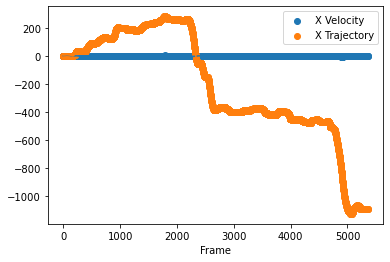

In [40]:

ws, wm = create_warp_stack('out/*.ppm', 'mask_out/*.png')
i,j = 0,2
plt.scatter(np.arange(len(ws)), ws[:,i,j], label='X Velocity')
plt.plot(np.arange(len(ws)), ws[:,i,j])
plt.scatter(np.arange(len(ws)), np.cumsum(ws[:,i,j], axis=0), label='X Trajectory')
plt.plot(np.arange(len(ws)), np.cumsum(ws[:,i,j], axis=0))
plt.legend()
plt.xlabel('Frame')
# plt.savefig(name+'_trajectory.png')

smoothed_warp, smoothed_trajectory, original_trajectory = moving_average(ws, sigma_mat= np.array([[1000,15, 10],[15,1000, 10]]))
#smoothed_warp_mask, smoothed_trajectory_mask, original_trajectory_mask = moving_average(wm, sigma_mat= np.array([[1000,15, 10],[15,1000, 10]]))
new_imgs, msks = apply_warping_fullview_mask(images=imgs, warp_stack=ws-smoothed_warp, PATH='out/*.ppm',PATH2='mask_out/*.png')

In [6]:
ws.shape

(6097, 2, 3)